# XGBoost: 커플 성사 여부 예측하기

`부스팅`: 순차적으로 트리를 만들어 이전 트리로부터 더 나은 트리를 만들어내는 알고리즘

- 랜덤 포레스트보다 훨씬 빠른 속도와 더 좋은 예측 능력을 보여줌

- 장점
    - 예측 속도가 상당히 빠르며, 예측력 또한 좋음
    - 변수 종류가 많고 데이터가 클수록 상대적으로 뛰어난 성능을 보여줌
- 단점
    - 복잡한 모델인 만큼, 해석에 어려움이 있음
    - 더 나은 성능을 위한 하이퍼파라미터 튜닝이 까다로움
- 유용한 곳
    - 종속변수가 연속형 데이터인 경우든 범주형 데이터인 경우든 모두 사용할 수 있음
    - 이미지나 자연어가 아닌 표로 정리된 데이터의 경우, 거의 모든 상황에 활용할 수 있음

## 10.1 문제 정의: 한눈에 보는 예측 목표

- 종속변수: match(커플 성사 여부)
- 평가지표: 정확도, 혼동 행렬, 분류 리포트

## 10.2 라이브러리 및 데이터 불러오기, 데이터 확인하기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_url='https://media.githubusercontent.com/media/musthave-ML10/data_source/main/dating.csv'
data=pd.read_csv(file_url)
data.head()

,has_null,gender,age,age_o,race,race_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,...,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
0,0,female,21.0,27.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,35.0,20.0,...,7.0,6.0,5.0,0.14,3.0,2.0,7.0,6.0,0.0,0
1,0,female,21.0,22.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,60.0,0.0,...,8.0,5.0,6.0,0.54,3.0,2.0,7.0,5.0,1.0,0
2,1,female,21.0,22.0,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,2.0,4.0,19.0,18.0,...,8.0,5.0,7.0,0.16,3.0,2.0,7.0,NaN,1.0,1
3,0,female,21.0,23.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,30.0,5.0,...,7.0,6.0,8.0,0.61,3.0,2.0,7.0,6.0,0.0,1
4,0,female,21.0,24.0,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,2.0,4.0,30.0,10.0,...,7.0,6.0,6.0,0.21,3.0,2.0,6.0,6.0,0.0,1


변수가 39개나 되어 중간에 생략부분이 있음

In [2]:
pd.options.display.max_columns=40 # 40개의 컬럼을 보도록 설정

In [3]:
data.head() # 전부 보임

,has_null,gender,age,age_o,race,race_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sincere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
0,0,female,21.0,27.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,9.0,7.0,7.0,6.0,5.0,0.14,3.0,2.0,7.0,6.0,0.0,0
1,0,female,21.0,22.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,7.0,8.0,7.0,8.0,5.0,6.0,0.54,3.0,2.0,7.0,5.0,1.0,0
2,1,female,21.0,22.0,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,2.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,15.0,20.0,20.0,15.0,15.0,15.0,5.0,8.0,9.0,8.0,5.0,7.0,0.16,3.0,2.0,7.0,NaN,1.0,1
3,0,female,21.0,23.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,7.0,6.0,8.0,7.0,6.0,8.0,0.61,3.0,2.0,7.0,6.0,0.0,1
4,0,female,21.0,24.0,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,2.0,4.0,30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,5.0,6.0,7.0,7.0,6.0,6.0,0.21,3.0,2.0,6.0,6.0,0.0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   has_null                       8378 non-null   int64  
 1   gender                         8378 non-null   object 
 2   age                            8283 non-null   float64
 3   age_o                          8274 non-null   float64
 4   race                           8315 non-null   object 
 5   race_o                         8305 non-null   object 
 6   importance_same_race           8299 non-null   float64
 7   importance_same_religion       8299 non-null   float64
 8   pref_o_attractive              8289 non-null   float64
 9   pref_o_sincere                 8289 non-null   float64
 10  pref_o_intelligence            8289 non-null   float64
 11  pref_o_funny                   8280 non-null   float64
 12  pref_o_ambitious               8271 non-null   f

- has_null: Null값이 있는지 여부
- age/age_o: age는 본인 나이, age_o는 상대방 나이
- race/race_o: 인종/상대인종
- importance_same_race/importance_same_religion: 인종과 종교를 중요시 여기는지에 대한 응답
- attractive, sincere, intelligence, funny, ambitious, shared_interests: 4가지 관점에서 평가된 항목
    - pref_o_xxx: 상대방이 해당항목을 얼마나 중요하게 생각하는가에 대한 응답
    - xxx_0: 상대방이 본인에 대한 해당 항목을 평가한 항목
    - xxx_important: 해당 항목에 대해 본인이 얼마나 중요하게 생각하는가에 대한 응답
    - xxx_partner: 본인이 상대방에 대한 해당 항목을 평가한 항목
- interests_correlate: 관심사 연관도
- expeceted_happy_with_sd_people: 스피드 데이팅을 통해 만난 사람과 함께할 때 얼마나 좋은지에 대한 기대치
- expected_num_interested_in_me: 얼마나 많은 사람이 나에게 관심을 보일지에 대한 기대치
- like: 파트너가 마음에 들었는지 여부
- guess_prob_liked: 파트너가 나를 마음에 들어했을지에 대한 예상
- met: 파트너를 스피드 데이팅 이벤트 이전에 만난 적이 있는지 여부

In [5]:
round(data.describe(),2)

,has_null,age,age_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sincere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
count,8378.00,8283.00,8274.00,8299.00,8299.00,8289.00,8289.00,8289.00,8280.00,8271.00,8249.00,8166.00,8091.00,8072.00,8018.00,7656.00,7302.00,8299.00,8299.00,8299.00,8289.00,8279.00,8257.00,8176.00,8101.00,8082.00,8028.00,7666.00,7311.00,8220.00,8277.00,1800.00,8138.00,8069.00,8003.00,8378.00
mean,0.87,26.36,26.36,3.78,3.65,22.50,17.40,20.27,17.46,10.69,11.85,6.19,7.18,7.37,6.40,6.78,5.47,22.51,17.40,20.27,17.46,10.68,11.85,6.19,7.18,7.37,6.40,6.78,5.47,0.20,5.53,5.57,6.13,5.21,0.05,0.16
std,0.33,3.57,3.56,2.85,2.81,12.57,7.04,6.78,6.09,6.13,6.36,1.95,1.74,1.55,1.95,1.79,2.16,12.59,7.05,6.78,6.09,6.12,6.36,1.95,1.74,1.55,1.95,1.79,2.16,0.30,1.73,4.76,1.84,2.13,0.28,0.37
min,0.00,18.00,18.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.83,1.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,24.00,24.00,1.00,1.00,15.00,15.00,17.39,15.00,5.00,9.52,5.00,6.00,6.00,5.00,6.00,4.00,15.00,15.00,17.39,15.00,5.00,9.52,5.00,6.00,6.00,5.00,6.00,4.00,-0.02,5.00,2.00,5.00,4.00,0.00,0.00
50%,1.00,26.00,26.00,3.00,3.00,20.00,18.37,20.00,18.00,10.00,10.64,6.00,7.00,7.00,7.00,7.00,6.00,20.00,18.18,20.00,18.00,10.00,10.64,6.00,7.00,7.00,7.00,7.00,6.00,0.21,6.00,4.00,6.00,5.00,0.00,0.00
75%,1.00,28.00,28.00,6.00,6.00,25.00,20.00,23.81,20.00,15.00,16.00,8.00,8.00,8.00,8.00,8.00,7.00,25.00,20.00,23.81,20.00,15.00,16.00,8.00,8.00,8.00,8.00,8.00,7.00,0.43,7.00,8.00,7.00,7.00,0.00,0.00
max,1.00,55.00,55.00,10.00,10.00,100.00,60.00,50.00,50.00,53.00,30.00,10.50,10.00,10.00,11.00,10.00,10.00,100.00,60.00,50.00,50.00,53.00,30.00,10.00,10.00,10.00,10.00,10.00,10.00,0.91,10.00,20.00,10.00,10.00,8.00,1.00


각 데이터의 최댓값이 다른 것으로 보아 데이터 수집방식 확인

중요도 관련 변수는 총 100점으로 각 항목에 분배해 적용

## 10.3 전처리: 결측치 처리

In [6]:
data.isna().mean()

has_null                         0.000000
gender                           0.000000
age                              0.011339
age_o                            0.012413
race                             0.007520
race_o                           0.008713
importance_same_race             0.009429
importance_same_religion         0.009429
pref_o_attractive                0.010623
pref_o_sincere                   0.010623
pref_o_intelligence              0.010623
pref_o_funny                     0.011697
pref_o_ambitious                 0.012772
pref_o_shared_interests          0.015397
attractive_o                     0.025304
sincere_o                        0.034256
intelligence_o                   0.036524
funny_o                          0.042970
ambitous_o                       0.086178
shared_interests_o               0.128432
attractive_important             0.009429
sincere_important                0.009429
intellicence_important           0.009429
funny_important                  0

대부분 결측치가 5% 미만
- XGBoost는 기본적으로 트리 베이스 모델이라 결측치를 채우기는 까다롭지 않음
- 중요도와 관련된 변수만 결측치 제거
    - 후에 중요도 X 점수 로 계산하기 때문
- 나머지는 의미없는 값인 -99로 채움

In [7]:
data=data.dropna(subset=['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
                        'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_important',
                        'sincere_important', 'intellicence_important', 'funny_important',
                         'ambtition_important', 'shared_interests_important'])

In [8]:
data=data.fillna(-99)

## 10.4 전처리: 피퍼 엔지니어링

나이차를 계산하기 위해 -99로 결측치 채운 값을 주의해야함

남자가 여자보다 많은지를 고려하기위해 성별도 생각해야함

In [9]:
def age_gap(x):
    if x['age']==-99:
        return -99
    elif x['age_o']==-99:
        return -99
    elif x['gender']=='female':
        return x['age_o']-x['age']
    else:
        return x['age']-x['age_o']

In [10]:
data['age_gap']=data.apply(age_gap,axis=1)

In [11]:
data['age_gap_abs']=abs(data['age_gap']) # 절댓값 적용

In [12]:
def same_race(x):
    if x['race']==-99:
        return -99
    elif x['race_o']==-99:
        return -99
    elif x['race']==x['race_o']:
        return 1
    else:
        return -1 # 나중에 크기를 확인하기 위해 0대신 -1을 사용
    
data['same_race']=data.apply(same_race, axis=1)

In [13]:
def same_race_point(x):
    if x['same_race']==-99:
        return -99
    else:
        return x['same_race'] * x['importance_same_race']
    
data['same_race_point']=data.apply(same_race_point, axis=1)

In [14]:
def rating(data, importance, score):
    if data[importance] == -99:
        return -99
    elif data[score] == -99:
        return -99
    else:
        return data[importance] * data[score]

In [15]:
data.columns[8:14]

Index(['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
       'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests'],
      dtype='object')

In [16]:
partner_imp=data.columns[8:14] # 상대방의 중요도
partner_rate_me=data.columns[14:20] # 본인에 대한 상대방의 평가
my_imp=data.columns[20:26] # 본인의 중요도
my_rate_partner=data.columns[26:32] # 상대방에 대한 본인의 평가

In [17]:
new_label_partner=['attractive_p', 'sincere_partner_p', 'intelligence_p', 'funny_p', 'ambition_p', 'shared_interests_p']

new_label_me=['attractive_m', 'sincere_partner_m', 'intelligence_m', 'funny_m', 'ambition_m', 'shared_interests_m']

In [18]:
# 중요도 * 평가
for i,j,k in zip(new_label_partner, partner_imp, partner_rate_me):
    data[i]=data.apply(lambda x: rating(x,j,k), axis=1)

In [19]:
for i,j,k in zip(new_label_me, my_imp, my_rate_partner):
    data[i]=data.apply(lambda x: rating(x,j,k), axis=1)

In [20]:
# object형 더미변수로 변환
data=pd.get_dummies(data,columns=['gender', 'race', 'race_o'], drop_first=True)

## 10.5 모델링 및 평가

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('match', axis=1), data['match'], test_size=0.2, random_state=100)

import xgboost as xgb
model=xgb.XGBClassifier(n_estimators=500, max_depth=5, random_state=100)

In [22]:
model.fit(X_train, y_train)

C:\Users\boo\anaconda3\envs\py36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
pred=model.predict(X_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_test, pred)

0.8616236162361623

모델링 없이 모든 경우를 0으로만 해도 84%의 성능이 나오므로 좋은 결과가 아님

In [24]:
print((confusion_matrix(y_test, pred)))

[[1291   74]
 [ 151  110]]


In [25]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1365
           1       0.60      0.42      0.49       261

    accuracy                           0.86      1626
   macro avg       0.75      0.68      0.71      1626
weighted avg       0.85      0.86      0.85      1626



위 두 표는 책과 다르게 나옴

0에 대한 예측에 비해 1에 대한 예측이 낮게 나옴

## 10.6 이해하기: 경사하강법

`경사하강법`: 머신러닝이 학습시킬 때 최소의 오차를 찾는 방법
- 오차 함수에 대한 경사도를 기준으로 매개변수를 반복적으로 이동해가며 최소 오차를 찾음
- 오차 함수의 미분 계수(기울기)가 0을 찾는 방법

- `지역 최솟값`: 기울기가 0인 지점이지만 전체범위에서 최솟값이 아님
- `전역 최솟값`: 전체 범위에서 가장 작은 값을 가지며 기울기가 0인 지점

## 10.7 하이퍼파라미터 튜닝: 그리드 서치

`그리드 서치`: 하이퍼파라미터 후보들을 입력해 각 조합에 대해 모델링해보고 최적의 조합을 알려줌

In [26]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'learning_rate': [0.01, 0.1, 0.3], # 보폭의 크기
    'max_depth': [5, 7, 10], # 각 트리의 깊이를 제한
    'subsample': [0.5, 0.7, 1], # 데이터의 일부만 사용
    'n_estimators': [300, 500, 1000] # 전체 나무의 개수를 정함
}

In [27]:
model=xgb.XGBClassifier()

In [28]:
gs_model = GridSearchCV(model, parameters, n_jobs=-1, scoring='f1', cv=5)

In [ ]:
gs_model.fit(X_train, y_train) #너무 오래걸려 실행 중단함

In [ ]:
gs_model.best_params_

In [ ]:
pred=gs_model.predict(X_test)

In [ ]:
accuracy_score(y_test, pred)

## 10.8 중요 변수 확인

In [29]:
model=xgb.XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=1000, subsample=0.5, random_state=100)
model.fit(X_train, y_train)

[16:28:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\boo\anaconda3\envs\py36\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
model.feature_importances_

array([0.02178125, 0.01137641, 0.00998134, 0.00984809, 0.01060789,
       0.01359383, 0.01065769, 0.01713987, 0.01186322, 0.01206678,
       0.01331671, 0.04854793, 0.01233603, 0.01430371, 0.02732428,
       0.01440853, 0.02333124, 0.01437325, 0.01104851, 0.01472255,
       0.00973702, 0.01481565, 0.01001215, 0.02409385, 0.01538233,
       0.01472   , 0.02749152, 0.01478216, 0.01670052, 0.01100918,
       0.0106856 , 0.02170104, 0.04928579, 0.01951623, 0.03824322,
       0.01167233, 0.01354653, 0.01223037, 0.01456301, 0.0113123 ,
       0.01188447, 0.01298039, 0.01511254, 0.01037562, 0.01001647,
       0.01314105, 0.01188815, 0.01242248, 0.01119815, 0.01119024,
       0.0116582 , 0.00895496, 0.01707342, 0.01282681, 0.03765631,
       0.02832991, 0.03117039, 0.01136704, 0.02328539, 0.0133381 ],
      dtype=float32)

In [32]:
feature_imp = pd.DataFrame({'features': X_train.columns, 'values':model.feature_importances_})

In [33]:
feature_imp.head()

,features,values
0,has_null,0.021781
1,age,0.011376
2,age_o,0.009981
3,importance_same_race,0.009848
4,importance_same_religion,0.010608


<AxesSubplot:xlabel='values', ylabel='features'>

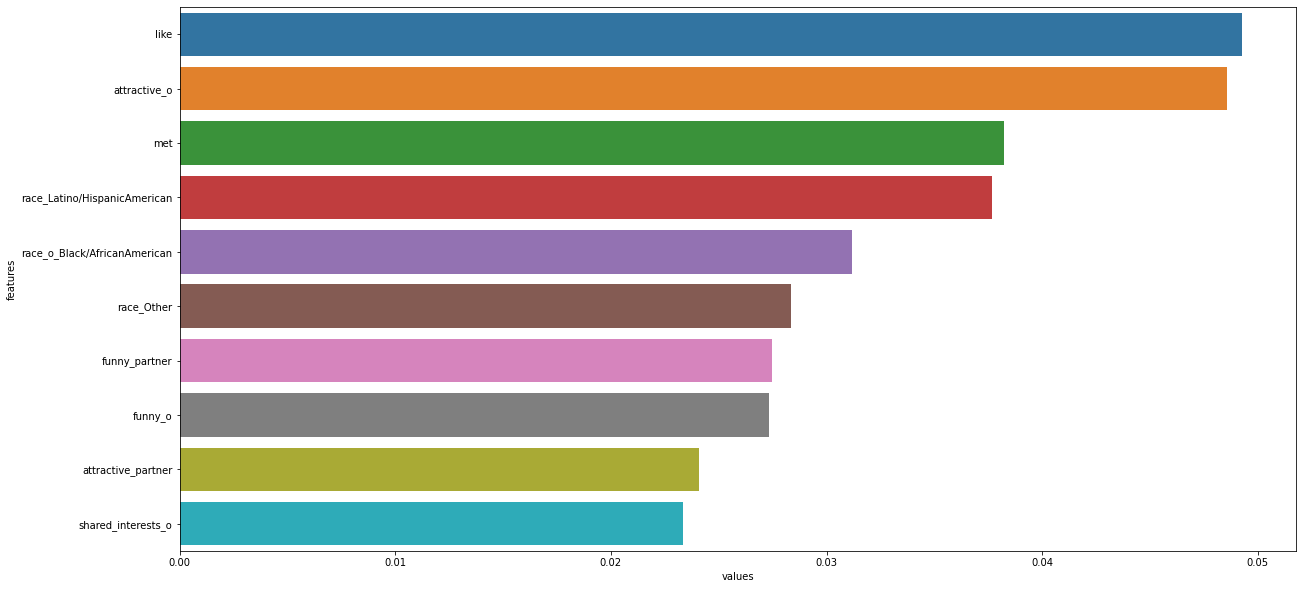

In [34]:
plt.figure(figsize=(20,10))
sns.barplot(x='values', y='features', data=feature_imp.sort_values(by='values', ascending=False).head(10))

## 10.9 이해하기:  XGBoost

결정 트리 -> 배깅 -> 랜덤 포레스트 -> 부스팅 -> 경사 부스팅 -> XG 부스팅

### 배깅

부트스트랩 훈련셋을 사용하는 트리 모델
> 부트스트랩: 데이터의 일부분을 무작위로 반복 추출하는 방법
- 오버피팅을 방지

### 부스팅과 에이다 부스팅
`부스팅`: 랜덤 포레스트에서 한 단계 더 발전한 방법
- 랜덤 포레스트는 각 트리가 독립적, 부스팅은 그렇지 않음
- 부스팅은 각 트리를 순차적으로 만들면서 이전 트리의 정보를 이용

`에이다 부스트`: 부스팅의 대표 알고리즘
- 단계적으로 트리를 만들 때 이전 단계에서의 분류 결과에 따라 각 데이터에 가중치를 부여/수정

### 경사 부스팅과 XGBoost

`경사부스팅`: 경사하강법을 이용하여 이전 모델의 에러를 기반으로 다음 트리를 만들어감

`XGBoost`: 경사 부스팅보다 계싼 성능 최적화와 알고리즘 개선을 함께 이룬 모델
- 2차 도함수를 활용해 더 적적한 이동 방향과 이동 크기를 찾아내어 더 빠른 시간에 전역 최솟값에 달함
- 정규화 하이퍼파라미터 지원

# 질문

`Chaper 10` : GridSearch를 사용했을 때 코드 실행이 오래걸립니다. 이러한 경우에 GridSearch와 비슷한 성능을 내면서 시간적 비용에서 더 좋은 결과를 보여주는 방식으로 어떠한 것이 있는지 궁금합니다.